# Examples of all decoders (except Kalman Filter)

In this example notebook, we:
1. Import the necessary packages
2. Load a data file (spike trains and outputs we are predicting)
3. Preprocess the data for use in all decoders
4. Run some example decoders and print the goodness of fit
5. Plot example decoded outputs

See "Examples_kf_decoder_hc" for a Kalman filter example. <br>
Because the Kalman filter utilizes different preprocessing, we don't include an example here (to keep this notebook more understandable)

## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files

Note that you may need to specify the path below

In [1]:
## (Configuration) Allows you to return multiple variables from a single cell ##
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
## Allows you to import files from another folder in current directory ## 
import os 
import sys 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
import sys

# # For Neural Network Models
# from tensorflow import keras 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder


## 2. Load Data
The data for this example can be downloaded at this [link](https://www.dropbox.com/s/e9mul73ur9omu5f/example_data_hc.pickle?dl=0).

It is the hc-2 dataset from [crcns](https://crcns.org/data-sets/hc/hc-2). Specifically, we use the dataset "ec014.333" 


The data that we load is in the format described below. We have another example notebook, "Example_format_data_hc", that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

 

In [4]:
folder='/Users/rbhatt6/Documents/MATLAB/' #ENTER THE FOLDER THAT YOUR DATA IS IN

# Opening Acc/Dec Data 
with open(folder+'sortInAccDec.pickle','rb') as f:
     sort_In=pickle.load(f,encoding='latin1') 
with open(folder+'sortOutXAccDec.pickle','rb') as f:
     sort_Out_X=pickle.load(f,encoding='latin1') 
with open(folder+'sortOutYAccDec.pickle','rb') as f:
     sort_Out_Y=pickle.load(f,encoding='latin1') 

## 3. Preprocess Data

### 3A. User Inputs
The user can define what time period to use spikes from (with respect to the output).

In [5]:
# # No Memory or Prediction Used 
# bins_before=0 #How many bins of neural data prior to the output are used for decoding
# bins_current=1 #Whether to use concurrent time bin of neural data
# bins_after=0 #How many bins of neural data after the output are used for decoding

# Using 500 ms (or 550ms b/c current_bin is the 11th bin used?) of preceding neural data to predict output in the current 50 ms bin
bins_before=10 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

### 3C. Split into training / testing / validation sets
Note that hyperparameters should be determined using a separate validation set. 
Then, the goodness of fit should be be tested on a testing set (separate from the training and validation sets).

### 3D. Process Covariates
We normalize (z_score) the inputs and zero-center the outputs.
Parameters for z-scoring (mean/std.) should be determined on the training set only, and then these z-scoring parameters are also used on the testing and validation sets.

#### User Options

In [6]:
training_range=[0, 0.8]
valid_range=[0.8,0.9]
testing_range=[0.9, 1]

In [7]:
## Computing R2s (and optionally the numerator and denominators for computing R2)
from Neural_Decoding.runModels import run_model

Wiener_R2s_X = run_model(sort_In, sort_Out_X, "Wiener", training_range, testing_range, valid_range, bins_before, bins_after, "score")
Wiener_R2s_Y = run_model(sort_In, sort_Out_Y, "Wiener", training_range, testing_range, valid_range, bins_before, bins_after,"score")
Wiener_Cascade_R2s_X = run_model(sort_In, sort_Out_X, "WienerCasade", training_range, testing_range, valid_range, bins_before, bins_after,"score")
Wiener_Cascade_R2s_Y = run_model(sort_In, sort_Out_Y, "WienerCasade", training_range, testing_range, valid_range, bins_before, bins_after,"score")

In [21]:
## Running decoder on X and Y components to get their nom and denom for later computing combined XY_FVAF
from Neural_Decoding.runModels import run_model

Wiener_parts_X = run_model(sort_In, sort_Out_X, "Wiener", training_range, testing_range, valid_range, bins_before, bins_after, "parts")
Wiener_parts_Y = run_model(sort_In, sort_Out_Y, "Wiener", training_range, testing_range, valid_range, bins_before, bins_after,"parts")
Wiener_Cascade_parts_X = run_model(sort_In, sort_Out_X, "WienerCasade", training_range, testing_range, valid_range, bins_before, bins_after,"parts")
Wiener_Cascade_parts_Y = run_model(sort_In, sort_Out_Y, "WienerCasade", training_range, testing_range, valid_range, bins_before, bins_after,"parts")

In [29]:
Wiener_parts_X[0][0][0]

2.5116250500720687

In [31]:
## Computing combined XY_R2s (i.e. XY_FVAF) for Wiener and Wiener Cascade results
from Neural_Decoding.metrics import compute_XY_FVAF

Wiener_R2s_XY = []
for i in range(len(Wiener_R2s_X)):
    #curr_bucket = Kalman_R2s_combined[i]
    vel_x_nom = Wiener_parts_X[i][0][0] # dim = (curr_bucket, nom, array->value)
    vel_x_denom = Wiener_parts_X[i][1][0] # dim = (curr_bucket, denom, array->value)
    vel_y_nom = Wiener_parts_Y[i][0][0] # dim = (curr_bucket, nom, array->value)
    vel_y_denom = Wiener_parts_Y[i][1][0] # dim = (curr_bucket, denom, array->value)

    curr_bucket_XY_FVAF = compute_XY_FVAF(vel_x_nom,vel_x_denom,vel_y_nom,vel_y_denom)
    Wiener_R2s_XY.append(curr_bucket_XY_FVAF)

Wiener_R2s_XY

Wiener_Cascade_R2s_XY = []
for i in range(len(Wiener_R2s_X)):
    #curr_bucket = Kalman_R2s_combined[i]
    vel_x_nom = Wiener_Cascade_parts_X[i][0][0] # dim = (curr_bucket, nom, array->value)
    vel_x_denom = Wiener_Cascade_parts_X[i][1][0] # dim = (curr_bucket, denom, array->value)
    vel_y_nom = Wiener_Cascade_parts_Y[i][0][0] # dim = (curr_bucket, nom, array->value)
    vel_y_denom = Wiener_Cascade_parts_Y[i][1][0] # dim = (curr_bucket, denom, array->value)

    curr_bucket_XY_FVAF = compute_XY_FVAF(vel_x_nom,vel_x_denom,vel_y_nom,vel_y_denom)
    Wiener_Cascade_R2s_XY.append(curr_bucket_XY_FVAF)

Wiener_Cascade_R2s_XY

[0.15306640583495879,
 0.08550544771062707,
 0.2871853113329216,
 0.27495262139458654,
 0.3401412049197926,
 0.3264429951693387,
 0.3096791188420551,
 0.22841778362465803,
 0.2732520228700396,
 0.29292655500406173,
 0.2969786622881263,
 0.18037671326618987,
 0.11023572711692609,
 0.05089014584843432,
 0.1452675760177038,
 0.2201344804435008]

[0.17616199729685578,
 0.12780831417930882,
 0.3088683259897822,
 0.29037894891031146,
 0.35252836078653993,
 0.35127774055747674,
 0.3215330975223858,
 0.2612778914360512,
 0.2744962565576373,
 0.29231745764312844,
 0.2965473454782016,
 0.17072395607983548,
 0.11591109562283186,
 0.039046852135818155,
 0.16483036271241025,
 0.22168090785303896]

In [17]:
# Wiener_R2s_X
# Wiener_R2s_Y
# Wiener_Cascade_R2s_X
# Wiener_Cascade_R2s_Y

[array([0.20123691]),
 array([0.04168588]),
 array([-0.09152728]),
 array([0.27572046]),
 array([0.40455634]),
 array([0.33800287]),
 array([-0.0197371]),
 array([0.29152715]),
 array([0.32724678]),
 array([0.21747873]),
 array([0.02616073]),
 array([0.09873408]),
 array([0.10439743]),
 array([-0.15179183]),
 array([-0.08840906]),
 array([0.25430382])]

In [19]:
# (Optional) Re-format the decoder outputs
Wiener_R2s_X_Final = []
Wiener_R2s_Y_Final = []
Wiener_Cascade_R2s_X_Final = []
Wiener_Cascade_R2s_Y_Final = []

for i in range(len(Wiener_R2s_X)):
    Wiener_R2s_X_Final.append(Wiener_R2s_X[i][0])
    Wiener_Cascade_R2s_X_Final.append(Wiener_Cascade_R2s_X[i][0])
    Wiener_R2s_Y_Final.append(Wiener_R2s_Y[i][0])
    Wiener_Cascade_R2s_Y_Final.append(Wiener_Cascade_R2s_Y[i][0])

# np.array(X_Comp_R2s_Weiner_Final)
# np.array(X_Comp_R2s_Weiner_Cascade_Final)
# np.array(Y_Comp_R2s_Weiner_Final)
# np.array(Y_Comp_R2s_Weiner_Cascade_Final)

In [16]:
# Saving results in a matlab file 

from scipy.io import savemat
import numpy

L = [Wiener_R2s_X, Wiener_R2s_Y, Wiener_R2s_XY, Wiener_Cascade_R2s_X, Wiener_Cascade_R2s_Y, Wiener_Cascade_R2s_XY]

FrameStack = np.empty((6,), dtype=object)
for i in range(len(L)):
    FrameStack[i] = L[i]

savemat("modelOutputsUpdated.mat", {"modelOutputs":FrameStack})

Text(0.5, 1.0, 'Wiener Filter')

Text(0.5, 1.0, 'Wiener Cascade Filter')

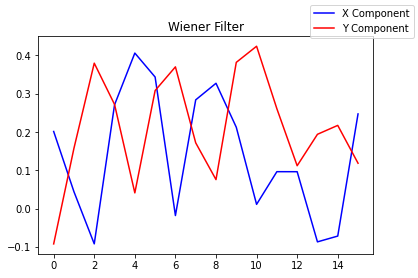

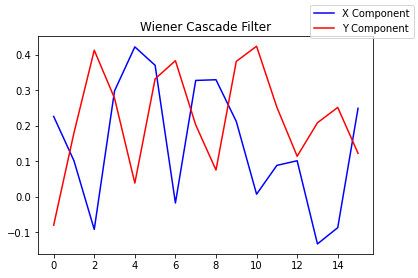

In [75]:
# Plot the results 

fig_Wiener = plt.figure()
plt.plot(X_Comp_R2s_Weiner_Final,'b')
plt.plot(Y_Comp_R2s_Weiner_Final, 'r')
fig_Wiener.legend(['X Component', 'Y Component'])
plt.title("Wiener Filter")

fig_Wiener_Casade = plt.figure()
plt.plot(X_Comp_R2s_Weiner_Cascade_Final,'b')
plt.plot(Y_Comp_R2s_Weiner_Cascade_Final, 'r')
fig_Wiener_Casade.legend(['X Component', 'Y Component'])
plt.title("Wiener Cascade Filter")